# May ??th, 2022 (h KABA 128)

**Motivation**:   <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(
    data,
    vmin=0.1,
    vmax=None,
    figsize=None,
    cmap='magma',
    ylabel_fontsize=11.5,
    show: bool = True, ):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (13.5, 1.6 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=False,
        reshape=True,
    )
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=ylabel_fontsize)
    remove_ticks(axes)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, axes


In [3]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 10, 20
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
d2p = {}

gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold'] = gr_bo.trim2d(gr_bo.project_vec())

props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
gr_bo.avg()
d2p['bold+1'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 95 + mg1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3))
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)
d2p['bold\npr95+mg'] = gr_bo.trim2d(gr_bo.project_vec())

# prune 99 + mg1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.99)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)
d2p['bold\npr99+mg'] = gr_bo.trim2d(gr_bo.project_vec())

pi_ca = {}
for b in [(0.01, 0.50), 0.5]:
    mice.setup_func_data(task, band_ca=b)
    gr_ca = Group(**props_ca).fit_group()
    gr_ca.avg()
    
    pr_ca = gr_ca.prune(n_resamples=int(7e3))
    gr_ca.run_pi = pr_ca['pi_prune_run']
    gr_ca.pi = pr_ca['pi_prune_avg']

    d2p[f'ca2\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())
    pi_ca[b] = gr_ca.pi

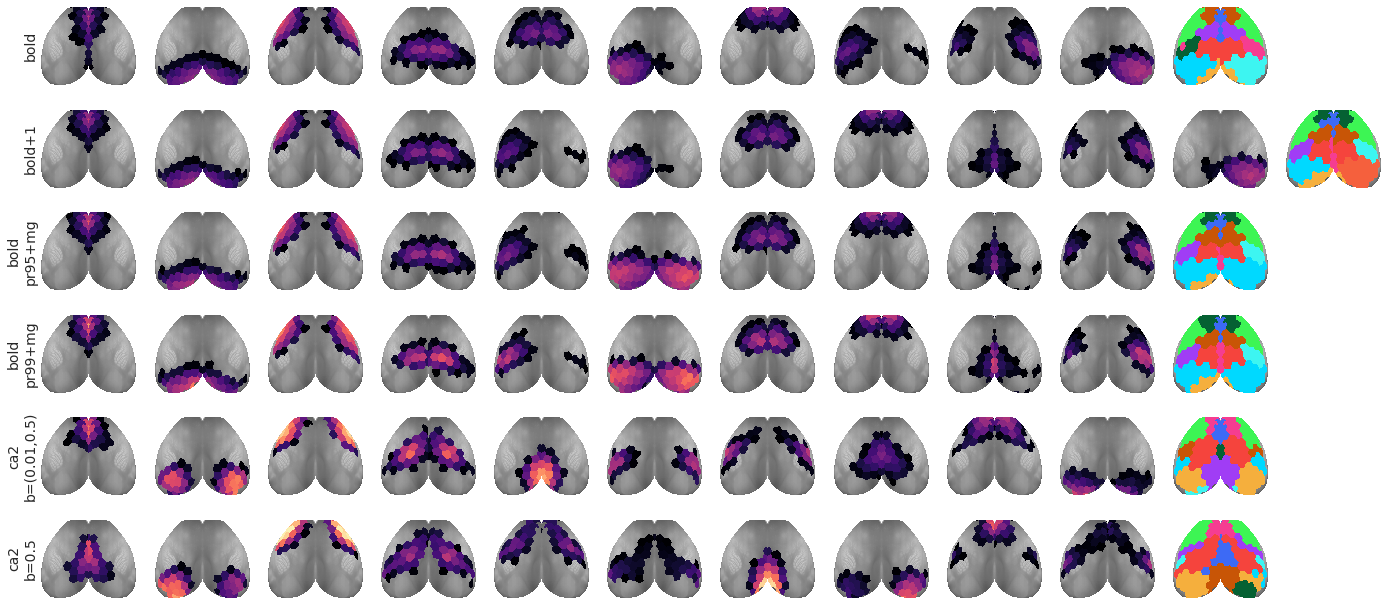

In [6]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 11), ylabel_fontsize=14)

## H

In [130]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

In [ ]:
"""b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
props_ca['num_k'] += 1
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_11 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_11, 2), 1), 0)
gr_ca.num_k"""

In [131]:
props_bo = {'mode': 'bold-lite', **props_base}
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_10 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_10, 2), 1), 0)
gr_bo.num_k

10

In [8]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_11 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_11, 2), 1), 0)
gr_bo.num_k

11

In [11]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo_mg = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_mg = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_mg, 2), 1), 0)
gr_bo.num_k

10

In [136]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.run_pi = bn.nanmean(gr_ca.run_pi, -3)

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

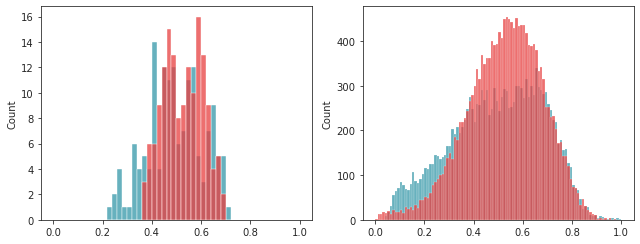

In [138]:
fig, axes = create_figure(1, 2, (9, 3.5))

sns.histplot(h_avg_ca_10, bins=np.linspace(0, 1, 51), color=pal['ca2'], ax=axes[0])
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51), color=pal['bold-lite'], ax=axes[0])

sns.histplot(h_ca_10[h_ca_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(h_bo_10[h_bo_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['bold-lite'], ax=axes[1])

plt.show()

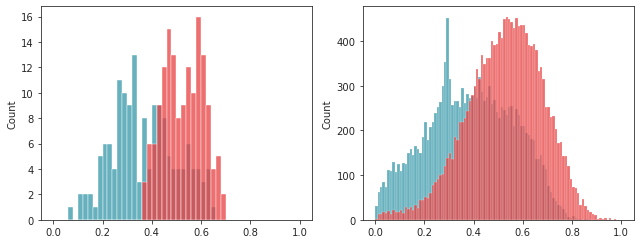

In [161]:
gr_ca.avg()
d2p[f'ca2(not-pr)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

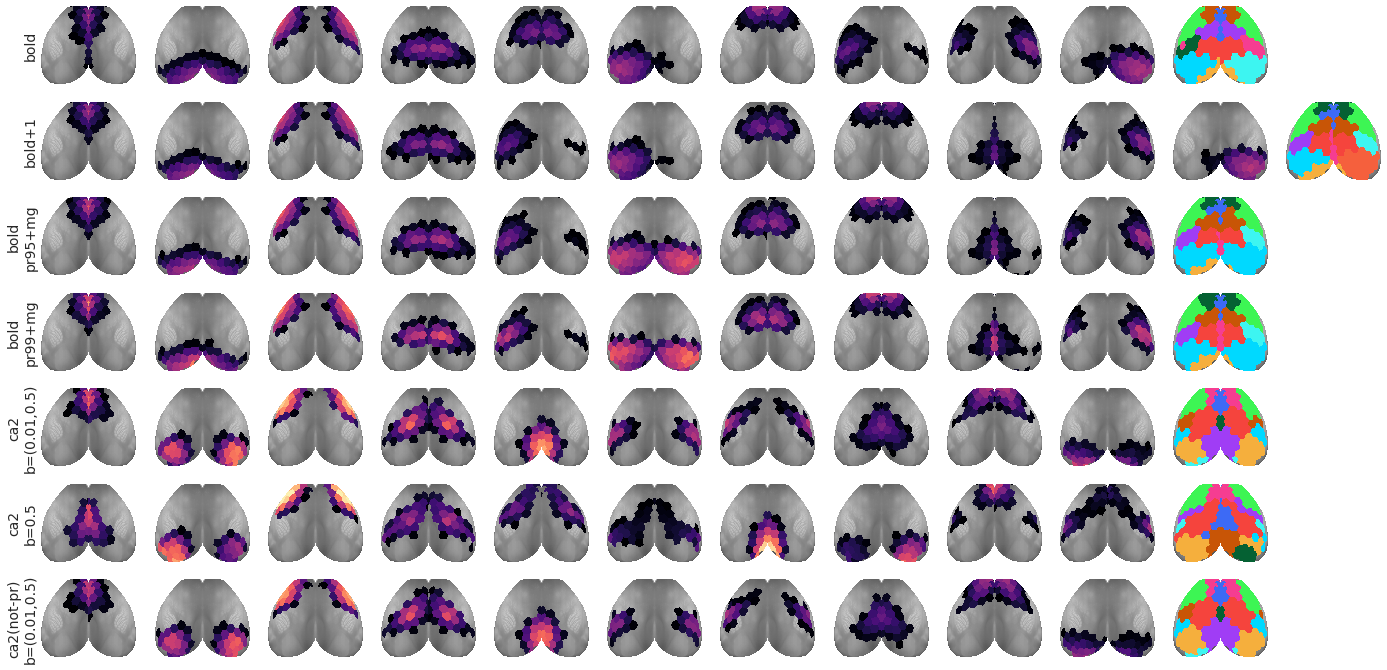

In [162]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 12), ylabel_fontsize=14)

<AxesSubplot:ylabel='Count'>

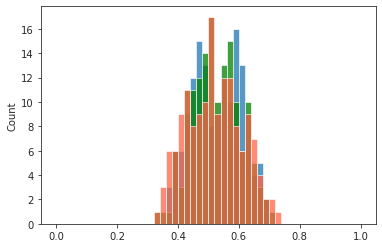

In [139]:
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51))
sns.histplot(h_avg_bo_11, bins=np.linspace(0, 1, 51), color='g')
sns.histplot(h_avg_bo_mg, bins=np.linspace(0, 1, 51), color='tomato')

In [163]:
trh_ca_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_ca_10, add_disjoint=False))
trh_bo_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_10, add_disjoint=False))
trh_bo_11 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_11, add_disjoint=False))
trh_bo_mg = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_mg, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca_10), np.nanmin(h_avg_bo_10), np.nanmin(h_avg_bo_11), np.nanmin(h_avg_bo_mg))
vmax = max(np.nanmax(h_avg_ca_10), np.nanmax(h_avg_bo_10), np.nanmax(h_avg_bo_11), np.nanmax(h_avg_bo_mg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.23037689538563905, 0.724035911433707)

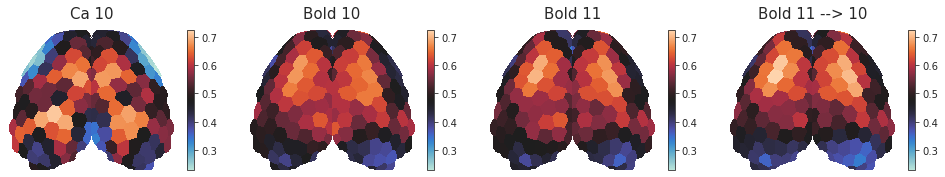

In [141]:
fig, axes = create_figure(1, 4, (13.5, 2.4))

im = axes[0].imshow(mwh(trh_ca_10['proj-top'][0] < vmin, trh_ca_10['proj-top'][0]), **kw_im)
axes[0].set_title('Ca 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_bo_10['proj-top'][0] < vmin, trh_bo_10['proj-top'][0]), **kw_im)
axes[1].set_title('Bold 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_bo_11['proj-top'][0] < vmin, trh_bo_11['proj-top'][0]), **kw_im)
axes[2].set_title('Bold 11', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(mwh(trh_bo_mg['proj-top'][0] < vmin, trh_bo_mg['proj-top'][0]), **kw_im)
axes[3].set_title('Bold 11 --> 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[3])

remove_ticks(axes)
plt.show()

In [142]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_mg)

(0.9207048579946774, 3.561061905557345e-63)

In [143]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_11)

(0.9580061746150019, 2.8609405138619793e-83)

In [144]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_bo_11)

(0.9634534518516699, 1.045062568998126e-87)

In [147]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_ca_10)

(0.4332918165008459, 2.4652039288401117e-08)

In [148]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_ca_10)

(0.3801225500857732, 1.3629250608234312e-06)

### Conclusion: for entropy do not use mg, mg is just for visualization of communities
- For other statistics also do not use mg, just find out how to cut data from say num k = 11 and then somehow average the two communities to be mg-ed and that gives u a single number for that community

## Difference map

### ca_10 vs bo_10

In [149]:
y1 = h_bo_10.reshape(-1, h_bo_10.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [150]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [151]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [152]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

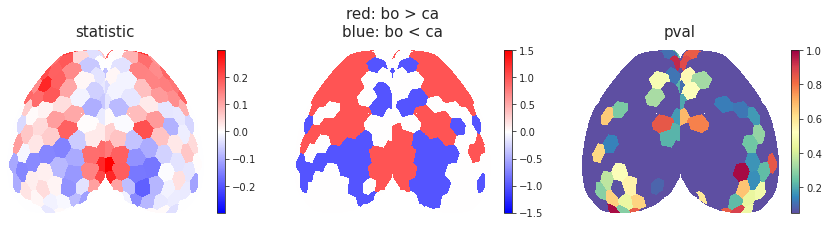

In [155]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

### ca_10 vs bo_mg

In [156]:
y1 = h_bo_mg.reshape(-1, h_bo_mg.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [157]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [158]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [159]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

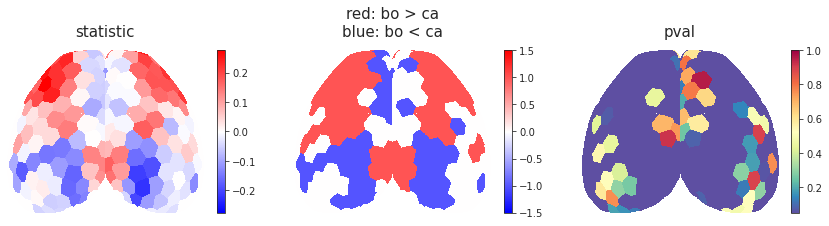

In [160]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

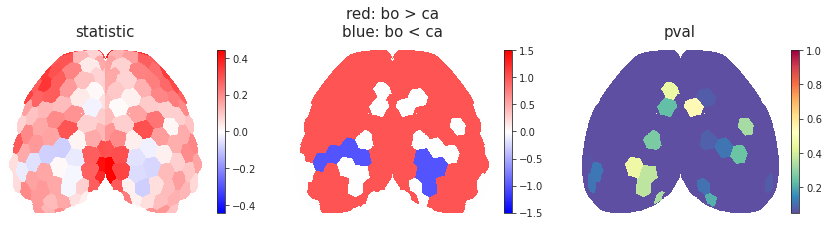

In [56]:
from statsmodels.stats.multitest import multipletests

<AxesSubplot:>

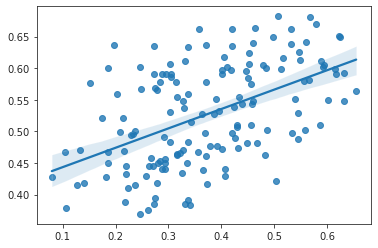

In [116]:
sns.regplot(h_avg_ca_10, h_avg_bo_10)

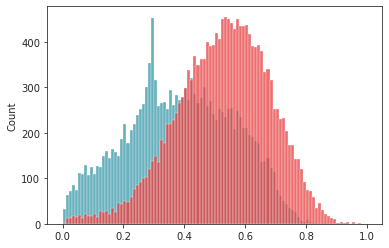